<a href="https://colab.research.google.com/github/RaphaelGervillie/ProjetFinEtude/blob/main/generation_de_legende2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Génération de légendes avec de l'attention visuelle

##Introduction



L'objectif des dux ateliers est de construire et entrainé un modèle qui génère une légendee à partir d'une image.

Par exemple, l'image ci-dessous aurait comme légende "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

Le lien entre image et texte se fera notemment à l'aide d'un modèle d'attentioin qui permet de visualiser sur quelle partie de l'image se focalise le modèle pour le choix de chaque mot.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

L'architecture construitte est similaire à [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).


Ce notebook se décompose en deux parties. Tout d'abord le code pour charger la base de données, préparer les exemples, et les visualiser est fourni en section *Données*. Puis vous constuirez votre modèle, apprendrez ses paramètres, et le testerez en sections *Modèle*, *Entrainement*, et *Tests*.



## Imports

In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

## Données

### Téléchargement et préparation de la base de données MS-COCO

Vous utiliserez [la base de données MS-COCO](http://cocodataset.org/#home) pour entrainer votre modèle. La base de données contient environ 82 000 images, chacune étant associée au minimum à 5 légendes. Vous commencerez par entrainer votre modèle sur une petite portion des données : 30 000 légendes pour nviron 20 000 images.

Le code ci-après télécharge (sur la machine virtuelle de google exécutant le notebook) et extrait la base de données. **Attention: long téléchargement en vue**.

In [2]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

252878848/252872794 [==============================] - 16s 0us/step


### Réduction de la taille de la base de données

In [3]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [4]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [5]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will 
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(image_paths))
print(len(train_image_paths))

82783
6000


In [6]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A man standing alone using a cell phone. <end>


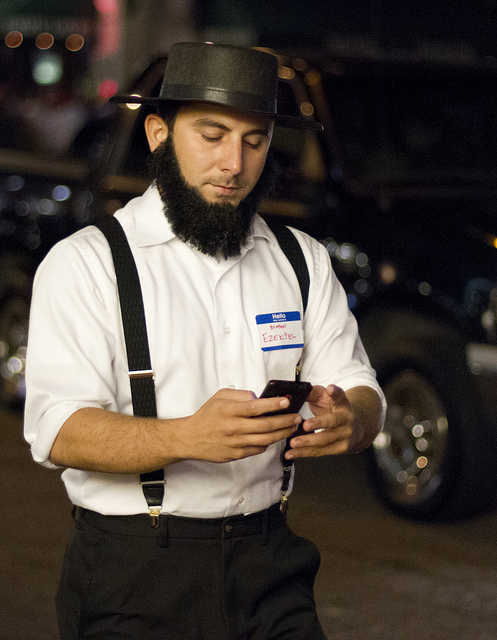

In [7]:
print(train_captions[21])
Image.open(img_name_vector[21])

### Transformation des images à l'aide d'InceptionV3
La première partie de votre modèle (complet) consiste à transfomer les images à l'aide d'InceptionV3 (qui est pré-entrainé sur Imagenet). Ses poids ne seront pas modifiés lors de l'apprentissage, donc cette transformation est faite en avance et le modèle (partiel) que vous construirez  prendra directement les images transformées en entrée.

Vous allez donc dès maintenant créer les images transformées, et les stocker sur le disque de la machine virtuelle car leur version transformée ne tiendrait pas en mémoire vive. 






Pur ce faire, vous avez besoin d'un modèle correspondant aux couches convolutives de InceptionV3. Les dimensions de sa sortie sont ```8x8x2048```.


In [8]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 5s 0us/step


In [9]:
image_features_extract_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Avant de fournir une image à ce modèle, il faut aussi la convertir au format utilisé par InceptioinV3 :  
* redimentionnement à 299px par 299px,
* [Normalisation des valeurs](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage)  (intervalle [-1, 1]).

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img) 
    #RGB. If a model expects BGR input, the channels will be permuted inside preprocess_input.
    return img, image_path

Et c'est partit !

(Ça peut à nouveau prendre du temps)


In [11]:
len(sorted(set(img_name_vector)))

6000

In [12]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

NotFoundError: ignored

In [ ]:
path_of_feature

'/content/train2014/COCO_train2014_000000581882.jpg'

### Transformation des légendes

Une série de transformations standards pour traiter des textes :

* on découpe les légendes en séquences de mots ;
* on se limite à 5,000 mots. Les autres mots sont remplacés parle mot `'UNK'` ;
* on crée les dictinnaires *mot vers indice* et *indice vers mot* ;
* on complète les séquences pour qu'elles aient la même longueur que la plus grande.

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [ ]:
train_captions[:10]

['<start> a person walking on a side walk near a parking meter  <end>',
 '<start> A man is causally walking down the street <end>',
 '<start> A man walks along a sidewalk adjacent to parked cars.  <end>',
 '<start> parked cars and a man walking on the side walk <end>',
 '<start> A man with his back turned walking down the sidewalk. <end>',
 '<start> A man wearing a suit with a blue tie stands near a table that holds a large cake and a woman in black holds a knife to the top of the cake. <end>',
 '<start> A man and woman standing next to a table posing while cutting a cake. <end>',
 '<start> A woman cutting a cake sitting on top of a white table. <end>',
 '<start> Elegantly dress man with woman cutting a ceremonial cake. <end>',
 '<start> a man with a tie and eye glasses watching a woman <end>']

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
print(len(cap_vector[0]))
print(len(cap_vector[1]))

43
43


In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

43

### Séparation entrainement vs. validation

In [ ]:
print(img_name_vector[0])
print(cap_vector[0])
print(len(img_name_vector))

/content/train2014/COCO_train2014_000000325935.jpg
[  3   2  30  61   5   2  67 308  41   2 200 386   4   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]
30008


In [ ]:
img_to_cap_vector = collections.defaultdict(list) # création dico
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
print("Before shuffle",img_keys[0])
random.shuffle(img_keys)
print("After shuffle",img_keys[0])


slice_index = int(len(img_keys)*0.8) # 6000 * 0.8
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]


Before shuffle /content/train2014/COCO_train2014_000000325935.jpg
After shuffle /content/train2014/COCO_train2014_000000411748.jpg


In [ ]:
img_name_train_keys[0]
img_to_cap_vector[img_name_train_keys[0]][0]

array([   3,    2,  137,  177,   91,  197, 1860,   96,    2,   77,   19,
        354,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len) # multiplie par le nombre de légendes.
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24007, 24007, 6001, 6001)

### Creation d'un objet `tf.data.Dataset` pour l'entrainement

Remarquez que la liste des images en entrainement (`img_name_train`) est une liste de noms de fichiers. Donc, à chaque fois que l'on fait appel à l'objet `dataset` pour fournir une mini-batch, celui-ci

1. sélectionne un sous-ensemble (de noms) d'images,
2. charge la version transformée des ces images (c'est le rôle de la fonction `map_func`),
3. et retourne le mini-batch ainsi obtenu.


In [ ]:
len(img_name_train)

24007

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
print(num_steps)
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

375


In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# Example of usage
from itertools import islice

for (batch, (img_tensors, targets)) in islice(enumerate(dataset), 1):
    for (ex_id, (img_tensor, target)) in islice(enumerate(zip(img_tensors, targets)), 3):
        print('\n-----------------------------------------')
        print(f'exemple {ex_id}')
        print('------')
        print(f'--- input: {img_tensor.numpy().shape}')
        print(f'--- output: {len(target.numpy())}')
        print(f'--- output as a string: {" ".join([tokenizer.index_word[i] for i in target.numpy() if i not in [0]])}')



-----------------------------------------
exemple 0
------
--- input: (64, 2048)
--- output: 43
--- output as a string: <start> a blonde woman using a cleaning device on her teeth <end>

-----------------------------------------
exemple 1
------
--- input: (64, 2048)
--- output: 43
--- output as a string: <start> a man wearing red and black hitting a tennis ball <end>

-----------------------------------------
exemple 2
------
--- input: (64, 2048)
--- output: 43
--- output as a string: <start> a coffee pot dishwasher and microwave sit in a kitchen <end>


#### Q: Quelles sont les dimentions d'entrée et de sortie d'un mini-batch ?

#### Q: Quelle est la dimension du tensor représentant **1** mot ?

# Modèle (v1)


Commencez par implémenter un modèle simple :
* les attributs de l'image sont concaténés en un seul vecteur de taille 64 x 2048, et ce vecteur passe dans une couche complètement connecté de taille `units`. Le tout est réalisé par un premier modèle que l'on nomme `encoder` ;
* les attributs générés par `encoder` sont utilisés comme état caché initial d'une couche GRU. L'entrée de cette couche est le début d'une légende représentée par une sequence de tokens (après plongement de chaque token dans un espace de dimension `embedding_dim`), sa sortie sert à prédire le prochain mot de la légende. Le tout est réalisé par un deuxième modèle que l'on nomme `decoder`

Aides :
* Si vous avez un doute sur le fonctionnement de l'ensemble, prenez le temps de regarder les exemles d'utilisation ci-après.
* Pour la partie GRU, vous pouvez vous inspirer de l'exemple fourni dans Moodle. 


#### Q: Complétez les deux classes ci-dessous.

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Prepare the initial state from the image
    def __init__(self, units):
        super(CNN_Encoder, self).__init__()

        # TODO: complete te code here if need be

    def call(self, x):

        # TODO: complete te code here if need be
        
        # initial state shape == (batch_size, units)
        return initial_state

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, units, vocab_size, embedding_dim):
    super(RNN_Decoder, self).__init__()

        # TODO: complete te code here if need be

  def call(self, x, initial_state):

    # TODO: complete te code here if need be

    # pred shape == (batch_size, vocab)
    return pred, state

In [ ]:
encoder = CNN_Encoder(units)
decoder = RNN_Decoder(units, vocab_size, embedding_dim)

Usage with an input of increasing size

In [ ]:
img_tensors, targets = next(dataset.as_numpy_iterator())
print(img_tensors.shape, targets.shape)

# the initial state is the image encoding
initial_state = encoder(img_tensors)
print(f'initial_state shape: {initial_state.shape}')

for prefix_len in range(1, 5):
  print('\n-------------------------')
  # expand_dims to handle only one example
  prefix = targets[:, :prefix_len]
  target = targets[:, prefix_len]
  print(f'text input shape: {prefix.shape}')
  print(f'output shape: {target.shape}')
  pred, _ = decoder(prefix, initial_state)
  print(f'prediction shape: {pred.shape}')

  print(f'input: "{" ".join([tokenizer.index_word[i] for i in prefix[0] if i not in [0]])}"')
  print(f'output: "{tokenizer.index_word[target[0]]}"')
  print(f'prediction: "{tokenizer.index_word[np.argmax(pred.numpy()[0])]}"')

(64, 64, 2048) (64, 51)
initial_state shape: (64, 512)

-------------------------
text input shape: (64, 1)
output shape: (64,)
prediction shape: (64, 5001)
input: "<start>"
output: "several"
prediction: "slender"

-------------------------
text input shape: (64, 2)
output shape: (64,)
prediction shape: (64, 5001)
input: "<start> several"
output: "cross"
prediction: "cozy"

-------------------------
text input shape: (64, 3)
output shape: (64,)
prediction shape: (64, 5001)
input: "<start> several cross"
output: "country"
prediction: "cozy"

-------------------------
text input shape: (64, 4)
output shape: (64,)
prediction shape: (64, 5001)
input: "<start> several cross country"
output: "skiers"
prediction: "cuddling"


## Entrainement

Avec le modèle proposé, la fonction de perte est à construire itérativement :erreur en prédiction pour le deuxième mot, puis pour le troisième, puis pour le quatirème, ... Du coup, l'itération sur les mini-batch, et le calcul et l'application du gradient pour chaque mini-batch sont à coder "à la main". Notez que pour calculer le gradient dans la function `train_step` (ligne `gradients = tape.gradient(loss, trainable_variables)`), on commence par une passe *forward* pour calculer la fonction de perte (contenu du block ```with tf.GradientTape() s tape:```).


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# a specific cost function to focuss on non-paded tokens
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  with tf.GradientTape() as tape:
      # the initial state is the image encoding
      state = encoder(img_tensor)

      # Compute the loss function for the whole sequence
      # (except the first token which is always "<start>")
      # Tokens to predict are considered 1 by 1
      for i in range(1, target.shape[1]):
          # only last character to input
          # but shown as a sequence of length 1
          dec_input = tf.expand_dims(target[:, i],1)

          prediction, state = decoder(dec_input, state)

          loss += loss_function(target[:, i], prediction)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

total_loss = 0
inputs, targets = next(dataset.as_numpy_iterator())
loss, total_loss = train_step(inputs, targets)
print(f'batch loss: {loss.numpy()}')

batch loss: 685.6473388671875


In [ ]:
EPOCHS = 10

loss_plot = []
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 10 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.0493
Epoch 1 Batch 10 Loss 0.0057
Epoch 1 Batch 20 Loss 0.0804
Epoch 1 Batch 30 Loss 0.4237
Epoch 1 Batch 40 Loss 0.0053
Epoch 1 Batch 50 Loss 0.0623
Epoch 1 Batch 60 Loss 0.0465
Epoch 1 Batch 70 Loss 0.0220
Epoch 1 Batch 80 Loss 0.0904
Epoch 1 Batch 90 Loss 0.0544
Epoch 1 Batch 100 Loss 0.0471
Epoch 1 Batch 110 Loss 0.0184
Epoch 1 Batch 120 Loss 0.0833
Epoch 1 Batch 130 Loss 0.0302
Epoch 1 Batch 140 Loss 0.0675
Epoch 1 Batch 150 Loss 0.0286
Epoch 1 Batch 160 Loss 0.0198
Epoch 1 Batch 170 Loss 0.0272
Epoch 1 Batch 180 Loss 0.0668
Epoch 1 Batch 190 Loss 0.0967
Epoch 1 Batch 200 Loss 0.0504
Epoch 1 Batch 210 Loss 0.1093
Epoch 1 Batch 220 Loss 0.1131
Epoch 1 Batch 230 Loss 0.1394
Epoch 1 Batch 240 Loss 0.0330
Epoch 1 Batch 250 Loss 0.0254
Epoch 1 Batch 260 Loss 0.0730
Epoch 1 Batch 270 Loss 0.0715
Epoch 1 Batch 280 Loss 0.0281
Epoch 1 Batch 290 Loss 0.0256
Epoch 1 Batch 300 Loss 0.0216
Epoch 1 Batch 310 Loss 0.0261
Epoch 1 Batch 320 Loss 0.0060
Epoch 1 Batch 330 Los

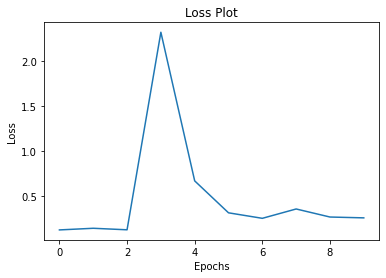

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Tests



### Sur les données de test


In [ ]:
def evaluate(image):
    # prepare the image
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    result = []

    # initial state and initial input (the token "<start>")
    state = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result.append('<start>')

    # Generate tokens one by one
    for i in range(max_length):
        prediction, state = decoder(dec_input, state)

        predicted_id = tf.random.categorical(prediction, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        # Stop predicting when the model predicts the end token
        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

!!! WARNING !!! Ce modèle est mauvais, ne vous attendez pas à des résultat extraordinaires...
Real Caption: <start> a person is trying to hit a ball with a tennis racket <end>
Prediction Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


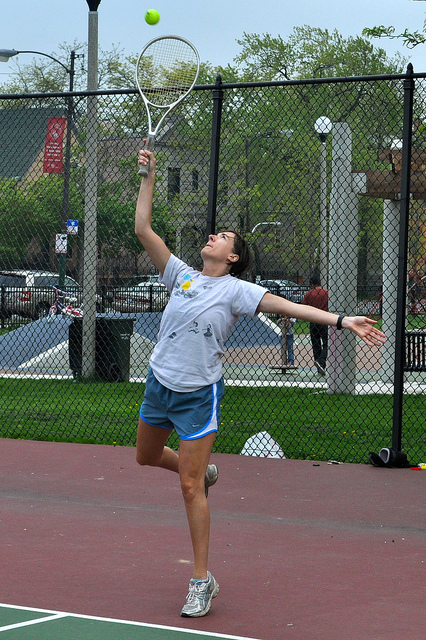

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result = evaluate(image)

print('!!! WARNING !!! Ce modèle est mauvais, ne vous attendez pas à des résultat extraordinaires...')
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
Image.open(image)

### Sur vos propres images

65536/64400 [==============================] - 0s 0us/step
Prediction Caption: a hipsters cutting board while ride on skis in his stomach in the waves and one board <end>


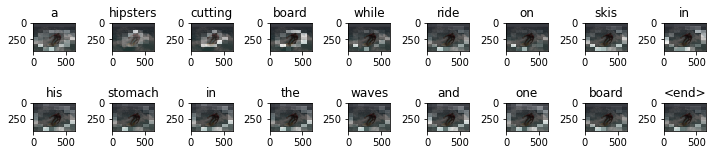

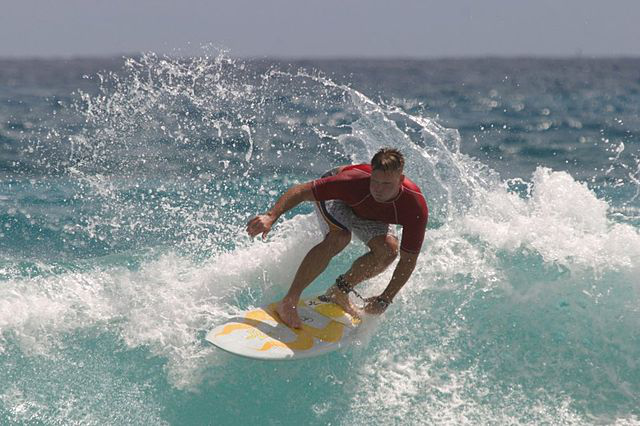

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
Image.open(image_path)

# Modèle (V2)

Essayez à présent de concevoir un modèle qui utilise un mécanisme d'attention sur l'image pour choisir chaque mot en fonction du reste de la légende. Vous pouvez par exemple commencer par le modèel suivant :

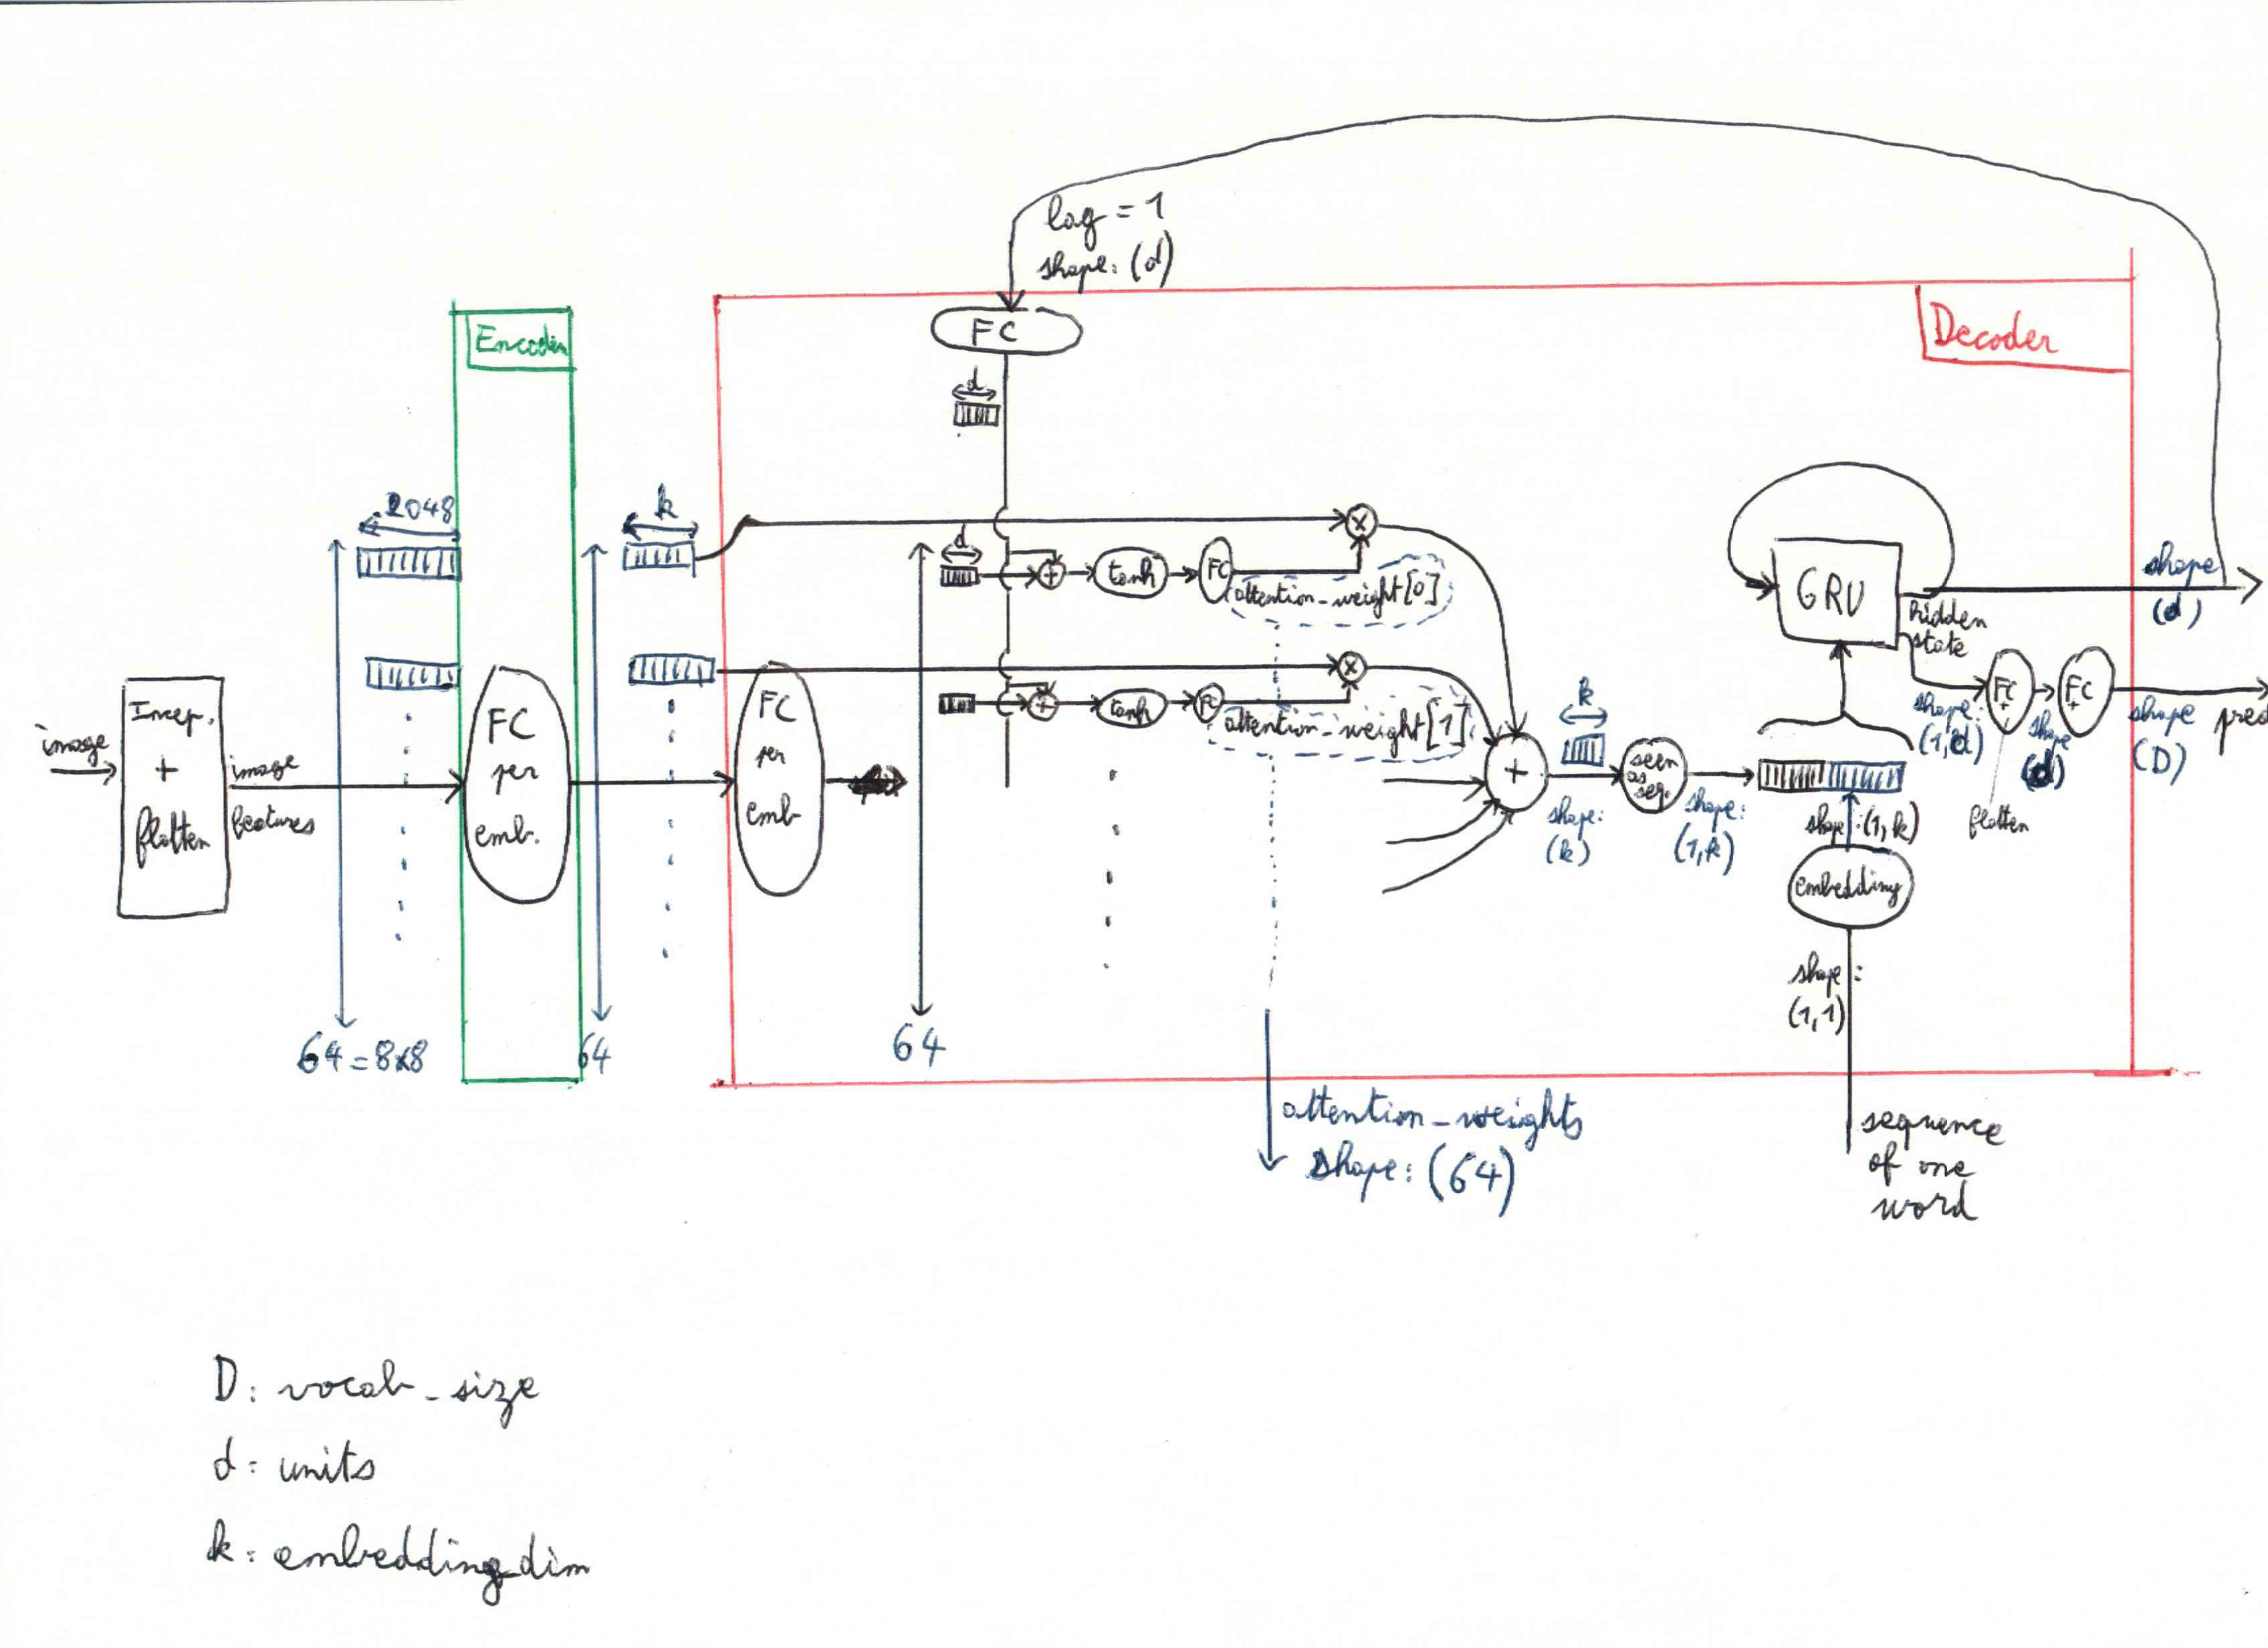

Cette architecture s'inspire de [cet encodeur](https://www.tensorflow.org/tutorials/text/nmt_with_attention), et de l'article [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf). Pour la partie générant le texte, vous pouvez vous inspirer de l'exemple fourni sur Moodle.

Pour ne passer l'image qu'une seule fois dans la partie encodage, vous devez fournir deux modèles:
* `encoder` : passe de l'image sous forme d'attributs aux attributs utilisés par votre réseau
    * attributs : dimension 64 x 2048
    * -> 
    * attributs : dimension 64 x `embedding_dim`
* `decoder`: passe du dernier mot choisi/vu, de l'image encodée, et de l'état caché de la couche GRU (à l'itération précédente), au mot suivant, l'état caché suivant, ainsi que les poids d'attention utilisées dans les calculs internes (pour afficher des graphiques).
    * mot : dimension 1 x 1, car vu comme une séquence de taille 1, et chaque mot est représenté par un entier
    * image : dimension 64 x `embedding_dim` 
    * état caché : dimension `units`
    * ->
    * mot : dimension 1 x 1, car vu comme une séquence de taille 1, et chaque mot est représenté par un entier
    * état caché : dimension `units`
    * poids d'attention : dimension 64. 

#### Q: Concevez votre propre modèle.

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()

        # TODO: complete te code here if need be
        
    def call(self, x):

        # TODO: complete te code here if need be
        
        # encoded_image shape  == (batch_size, 64, embedding_dim)
        return encoded_image

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()

    # TODO: complete te code here if need be

  def call(self, x, features, hidden):
    
    # TODO: complete te code here if need be

    # pred shape == (batch_size, vocab)
    # state shape == (batch_size, units)
    # attention_weights shape == (batch_size, 64, 1)
    return pred, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# a specific cost function to focuss on non-paded tokens
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Entrainement

Avec le modèle proposé, la fonction de perte est à construire itérativement :erreur en prédiction pour le deuxième mot, puis pour le troisième, puis pour le quatirème, ... Du coup, l'itération sur les mini-batch, et le calcul et l'application du gradient pour chaque mini-batch sont à coder "à la main". Notez que pour calculer le gradient dans la function `train_step` (ligne `gradients = tape.gradient(loss, trainable_variables)`), on commence par une passe *forward* pour calculer la fonction de perte (contenu du block ```with tf.GradientTape() s tape:```).


In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  # first character
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      # Compute the loss function for the whole sequence
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 3

loss_plot = []
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.8970
Epoch 1 Batch 100 Loss 1.1076
Epoch 1 Batch 200 Loss 0.9041
Epoch 1 Batch 300 Loss 0.8078
Epoch 1 Loss 0.989727
Time taken for 1 epoch 234.49820828437805 sec

Epoch 2 Batch 0 Loss 0.8761
Epoch 2 Batch 100 Loss 0.8028
Epoch 2 Batch 200 Loss 0.8221
Epoch 2 Batch 300 Loss 0.6953
Epoch 2 Loss 0.754795
Time taken for 1 epoch 146.64376187324524 sec

Epoch 3 Batch 0 Loss 0.7123
Epoch 3 Batch 100 Loss 0.6426
Epoch 3 Batch 200 Loss 0.6785
Epoch 3 Batch 300 Loss 0.6758
Epoch 3 Loss 0.680185
Time taken for 1 epoch 146.09056639671326 sec



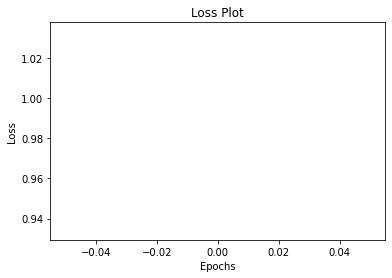

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Tests



### Sur les données de test


In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # Store the attention weights for every time step
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        # Stop predicting when the model predicts the end token
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> large cathedral during daylight on a cloudy day <end>
Prediction Caption: a tall neon clock tower with several section of water <end>


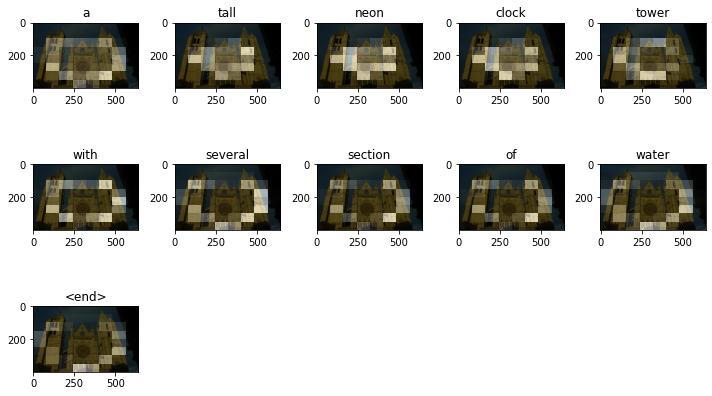

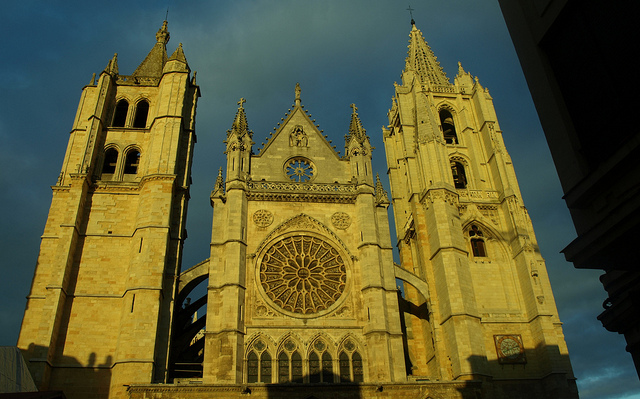

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

# opening the image
Image.open(image)

### Sur vos propres images

65536/64400 [==============================] - 0s 0us/step
Prediction Caption: a hipsters cutting board while ride on skis in his stomach in the waves and one board <end>


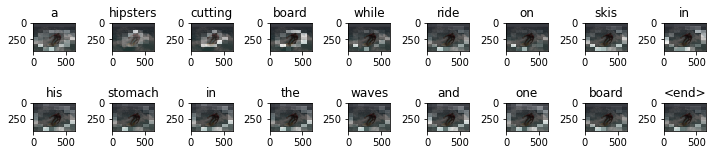

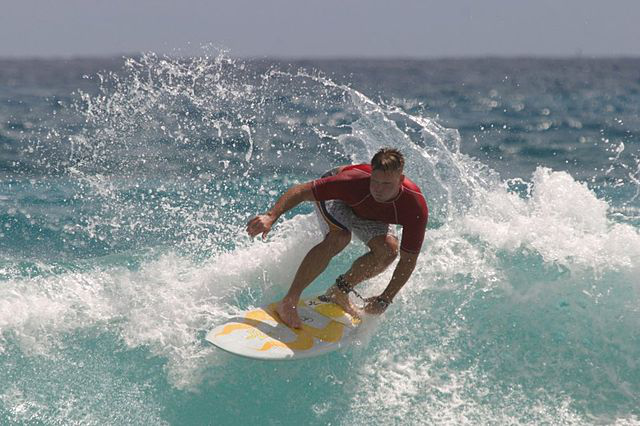

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)



# Copyright
Cet atelier est une traduction et une adaptation de https://www.tensorflow.org/tutorials/text/image_captioning

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.